Success!
Success!


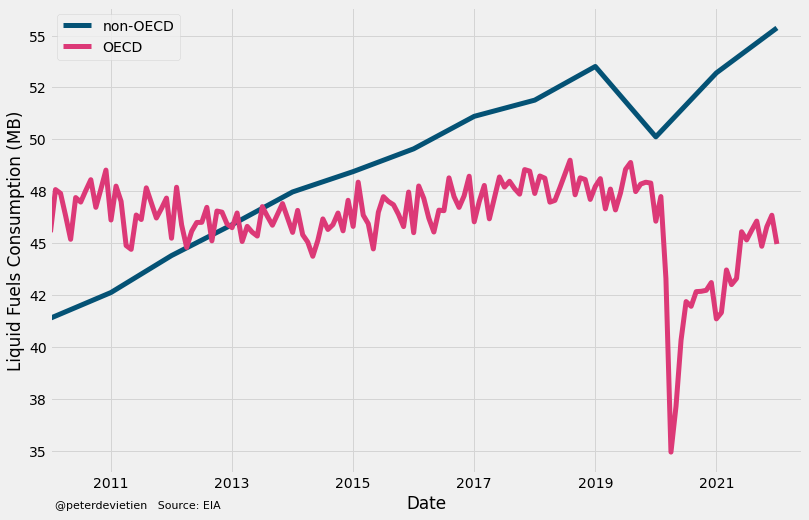

In [47]:
#Import libraries
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from dateutil.relativedelta import relativedelta
import matplotlib.ticker as ticker




# API Key from EIA
api_key = '4Cgy5BurMNMAhbo0RBIu3s5FFyyo37QEVmW0uBoz'
# PADD Names to Label Columns
# Change to whatever column labels you want to use.
SERIES_NAMES = ['NON-OECD CONSUMPTION','OECD CONSUMPTION']
# Enter all your Series IDs here separated by commas
SERIES_KEY = ['IEO.2021.REFERENCE.CNSM_LIQP_NNN_MBPD.A','STEO.PATC_OECD.M']
# Initialize list - this is the final list that you will store all the data from the json pull. Then you will use this list to concat into a pandas dataframe. 
final_data = []
# Choose start and end dates
startDate = '2010-01-01'
endDate = '2022-01-01'


# Pull in data via EIA API
for i in range(len(SERIES_KEY)):
    url = 'http://api.eia.gov/series/?api_key=' + api_key + '&series_id=' + SERIES_KEY[i]
    r = requests.get(url)
    json_data = r.json()
    
    if r.status_code == 200:
        print('Success!')
    else:
        print('Error')
    
    df = pd.DataFrame(json_data.get('series')[0].get('data'),
                      columns = ['Date', SERIES_NAMES[i]])
    df.set_index('Date', drop=True, inplace=True)
    final_data.append(df)


final_data[0]['Year']=final_data[0].index.astype(str)
final_data[0]['Month']='1'
final_data[0]['Day']='1'
final_data[0]['Date'] = pd.to_datetime(final_data[0][['Year','Month','Day']])
final_data[0].set_index('Date',drop=True,inplace=True)
final_data[0].sort_index(inplace=True)
final_data[0] = final_data[0][startDate:endDate]
final_data[0] = final_data[0].iloc[:,:5]


final_data[1]['Year']=final_data[1].index.astype(str).str[:4]
final_data[1]['Month']=final_data[1].index.astype(str).str[4:]
final_data[1]['Day']='1'
final_data[1]['Date'] = pd.to_datetime(final_data[1][['Year','Month','Day']])
final_data[1].set_index('Date',drop=True,inplace=True)
final_data[1].sort_index(inplace=True)
final_data[1] = final_data[1][startDate:endDate]
final_data[1] = final_data[1].iloc[:,:5]

## Piecewise linear interpolation for NON-OECD data
plyear=[]
plmonth=[]
plday=[]
plcons=[]
pldates=[]

pldate0=final_data[1].index[0]
pldatef=final_data[1].index[-1]

pldate=pldate0

while pldate <= pldatef:
    #print(pldate)
    #print(pldate.year)
    #print(pldate.month)
    year0=pldate.year
    yearf=year0 + 1
    ind0=final_data[0]['Year']==str(year0)
    indf=final_data[0]['Year']==str(yearf)
    cons0=final_data[0]['NON-OECD CONSUMPTION'][ind0]
    consf=final_data[0]['NON-OECD CONSUMPTION'][indf]
    consmonthly=np.linspace(cons0,consf,13)
    #print(cons0)
    #print(consf)
    #print(consmonthly[pldate.month-1])
    #print(consmonthly)

    plyear.append(str(pldate.year))
    plmonth.append(str(pldate.month))
    plday.append('1')
    if pldate < pldatef:
        plcons.append(consmonthly[pldate.month-1][0])
    else:
        plcons.append(cons0[0])

    pldates.append(pldate)
    pldate = pldate + relativedelta(months=1)

#print(plconslist)

final_data.append(final_data[1].copy())

final_data[2].rename(columns={"OECD CONSUMPTION":"NON-OECD CONSUMPTION"},inplace=True)
final_data[2]['NON-OECD CONSUMPTION'] = plcons
final_data[2]['Year']=plyear
final_data[2]['Month']=plmonth
final_data[2]['Day']=plday
final_data[2]['Date'] = pd.to_datetime(final_data[2][['Year','Month','Day']])
final_data[2].set_index('Date',drop=True,inplace=True)
final_data[2].sort_index(inplace=True)
final_data[2] = final_data[2].iloc[:,:5]

final_data[0]=final_data[2].copy()
del final_data[2]



crude = pd.concat(final_data,axis=1)






# Combine all the data into one dataframe
""" crude = pd.concat(final_data, axis=1)
# Create date as datetype datatype
crude['Year'] = crude.index.astype(str)
crude['Month'] = '1'
crude['Day'] = '1'
crude['Date'] = pd.to_datetime(crude[['Year','Month','Day']])

crude.set_index('Date',drop=True,inplace=True)
crude.sort_index(inplace=True)
crude = crude[startDate:endDate]
crude = crude.iloc[:,:5] """


# Generating Colours and Style
colors = {'NON-OECD CONSUMPTION':'#045275','TODAYS LEVEL':'#DC3977'}
plt.style.use('fivethirtyeight')

#fig, ax = plt.subplots()

# Creating the Visualization
plot = crude.plot(figsize=(12,8), 
                  color=list(colors.values()), 
                  linewidth=5, 
                  legend=False)



plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_ylabel('Liquid Fuels Consumption (MB)')

plot.set_xlim([date(2010,1,1),date(2022,6,1)])
plot.legend({'OECD','non-OECD'})

plot.text(x = crude.index[1], 
          y = 32.2,
          s = '@peterdevietien   Source: EIA', 
          fontsize = 11)

pngname='total_consumption_world'
plt.savefig('/Users/peter/projects/oil/post/'+pngname)


In [29]:
final_data

[            NON-OECD CONSUMPTION  Year Month Day
 Date                                            
 2021-01-01             53.200300  2021     1   1
 2021-02-01             53.380842  2021     2   1
 2021-03-01             53.561383  2021     3   1
 2021-04-01             53.741925  2021     4   1
 2021-05-01             53.922467  2021     5   1
 2021-06-01             54.103008  2021     6   1
 2021-07-01             54.283550  2021     7   1
 2021-08-01             54.464092  2021     8   1
 2021-09-01             54.644633  2021     9   1
 2021-10-01             54.825175  2021    10   1
 2021-11-01             55.005717  2021    11   1
 2021-12-01             55.186258  2021    12   1
 2022-01-01             55.366800  2022     1   1,
             OECD CONSUMPTION  Year Month Day
 Date                                        
 2021-01-01         41.348651  2021    01   1
 2021-02-01         41.651473  2021    02   1
 2021-03-01         43.706008  2021    03   1
 2021-04-01        